# INM707 Coursework Task 2
### Aaron Mir (Student Number: 160001207)

## Q-learning algorithm implemented for the Stronghold environment to find the best policy

In [ ]:
##--------------------Coding References---------------------## 
# Percentage of borrowed code: 5% - Q-learning Policy Plot and batch learning
# [1] Kim, Dan (2020) Distributed Q-Learning and SARSA, 
# Available at: https://github.com/csdankim/Intelli_Agent_Decision_Making/blob/master/2. Distributed Q-Learning and SARSA (Accessed: 22nd March 2021).

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The entire land is very misty, therefore the robot may not step where it is supposed to. Each move has a transition probability associated with it (0.7 to move to the chosen state or 0.3 to move to one of the other sides) (stochasticity). The stronghold has as many entrances from the mainland as (1/4)N and contains (1/5)N dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity).  The amount of shore that has traps on it is (1/4)N x rows of shore. The column immediately beside the stronghold is normal land to prevent entrance blocking. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being killed by enemy combatants or booby traps as fast as possible.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions.

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a penalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a penalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 1000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the sides.

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a booby-trap, gets killed by an enemy, reaches the goal/intelligence or runs out of time. The end-of-episode is modelled by transitioning to a zero-reward terminal state (all actions lead to that state). 

State of the agent: Governed by the state number of the cell it is on.

Rewards/Penalties: +1000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

Q-learning works by building a table of action and states and learning the 'q-values' at each location. The values in the table are randomly (or zero) initialized at first and are learnt through the bellman equation.
The bellman equation is 

<img src="Bellman Eq.png" alt="Bellman" width="1000"/>

The learning starts by first focussing more on the exploration and then on the exploitation. This is because in the start we don't know which is the optimal step and hence we must try to explore entire space and later do exploitation. Exploration simply means randomly selecting an action and exploitation means selecting the action with highest reward.

In [1]:
from stronghold.stronghold import Stronghold
from stronghold.Qlearning import Agent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from IPython.display import clear_output

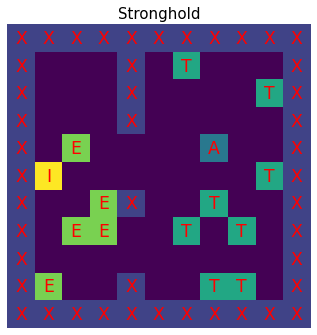

In [2]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

## Plotting Epsilon Decay Example

In [2]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.1               
discount = 0.999 
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn() # <- eps decay is commented out by default in Qlearning.py file
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  178.23218417167664


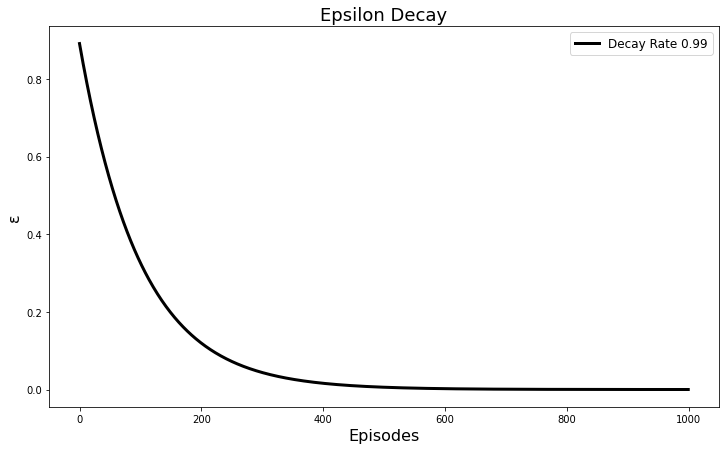

In [9]:
episodes_epsilon_decay = np.arange(0, 1000, 1)   
plt.figure(figsize=(12, 7))
plt.plot(episodes_epsilon_decay, eps_decay[:1000], 'k', linewidth=3.0, label='Decay Rate 0.99')
plt.title('Epsilon Decay', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('ε', fontsize=16)
plt.legend(fontsize=12, loc='best')
#plt.savefig('results/eps_decay/Epsilon_decay2')
plt.show()

## Investigating Stronghold Size Variation on Q-learning - Stronghold Simplicity Level 6

In [21]:
env_size = 11  # Stronghold size changed, rest stay the same
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999           
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ksize11 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  262.12180066108704


In [16]:
env_size = 15  # Stronghold size changed, rest stay the same
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999            
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ksize15 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  353.030232667923


In [11]:
env_size = 21  # Stronghold size changed, rest stay the same
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999            
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ksize21 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 442
Time taken for Q-learning is,  931.9524166584015


In [5]:
env_size = 31  # Stronghold size changed, rest stay the same
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999         
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ksize31 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 962
Time taken for Q-learning is,  3212.48167347908


In [6]:
env_size = 51  # Stronghold size changed, rest stay the same
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999          
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = False
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ksize51 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 2602
Time taken for Q-learning is,  5008.199355840683


In [2]:
# # loading the results for environment size variation graph
# avg_eval_rewards_e09lr01d999e10kl1ksize11 = pickle.load(open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize11'+'.q-learn', 'rb'))
# avg_eval_rewards_e09lr01d999e10kl1ksize15 = pickle.load(open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize15'+'.q-learn', 'rb'))         
# avg_eval_rewards_e09lr01d999e10kl1ksize21 = pickle.load(open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize21'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d999e10kl1ksize31 = pickle.load(open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize31'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d999e10kl1ksize51 = pickle.load(open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize51'+'.q-learn', 'rb')) 

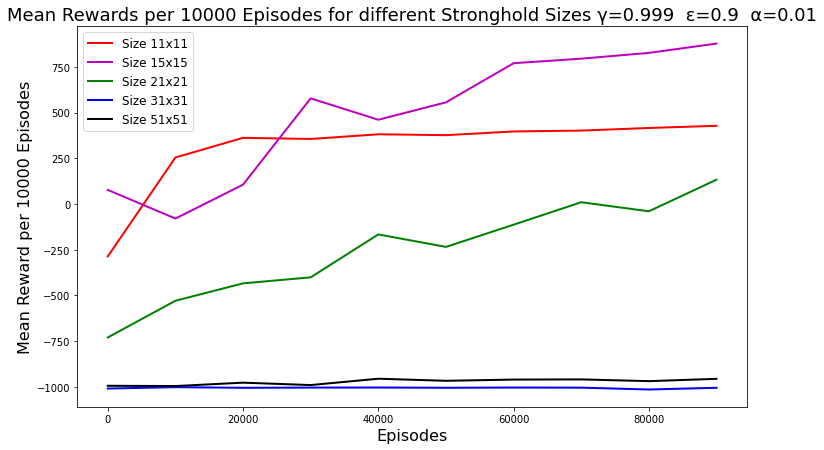

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr01d999e10kl1ksize11, 'r', linewidth=2.0, label='Size 11x11')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ksize15, 'm', linewidth=2.0, label='Size 15x15')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ksize21, 'g', linewidth=2.0, label='Size 21x21')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ksize31, 'b', linewidth=2.0, label='Size 31x31')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ksize51, 'k', linewidth=2.0, label='Size 51x51')
plt.title('Mean Rewards per 10000 Episodes for different Stronghold Sizes γ=0.999  ε=0.9  α=0.01', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 10000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
#plt.savefig('results/size_diff/Different_evironment_sizes')
plt.show()

In [25]:
# # saving the results for environment size variation graph
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ksize11, open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize11'+'.q-learn', 'wb'), -1)         
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ksize15, open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize15'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ksize21, open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize21'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ksize31, open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize31'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ksize51, open('results/size_diff/avg_eval_rewards_e09lr01d999e10kl1ksize51'+'.q-learn', 'wb'), -1) 

## Investigating Stronghold Simplicity Variation on Q-learning - Stronghold Size 15x15

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  630.8903193473816


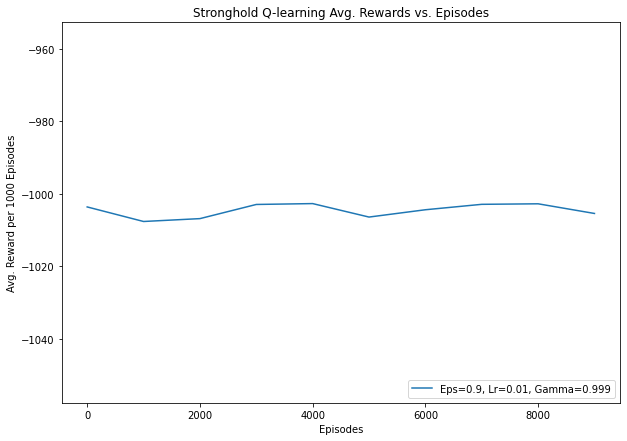

Best Policy


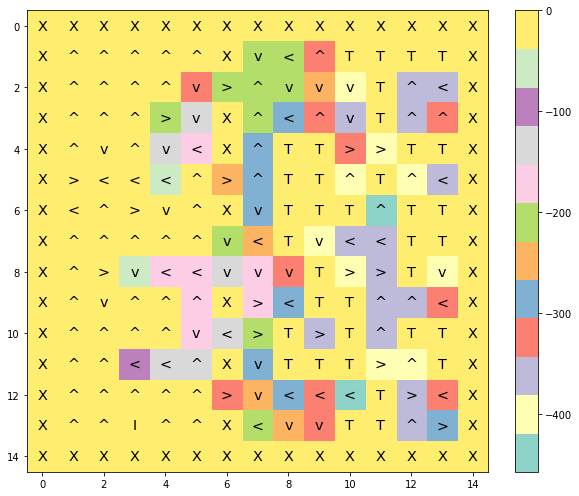

In [9]:
env_size = 15
simplicity = 2 # Simplicity value changed, rest stay the same
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999            
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ks2 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  740.7285635471344


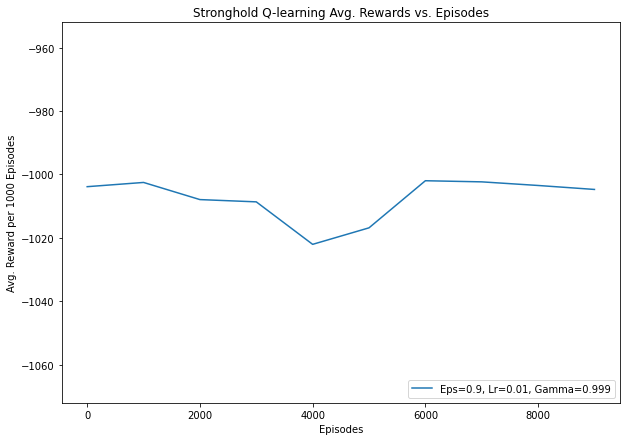

Best Policy


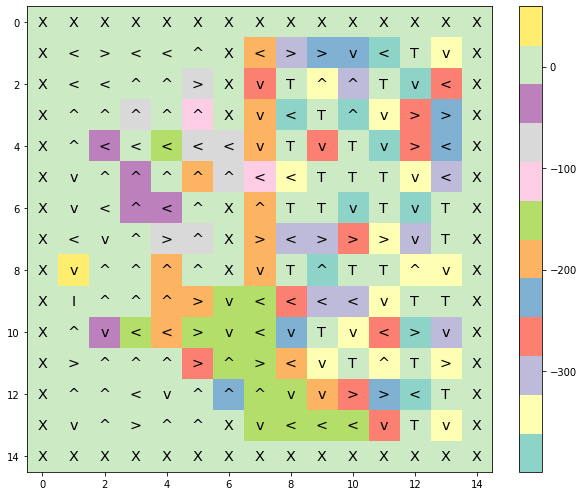

In [10]:
env_size = 15
simplicity = 3 # Simplicity value changed, rest stay the same
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999          
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ks3 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  1095.0593354701996


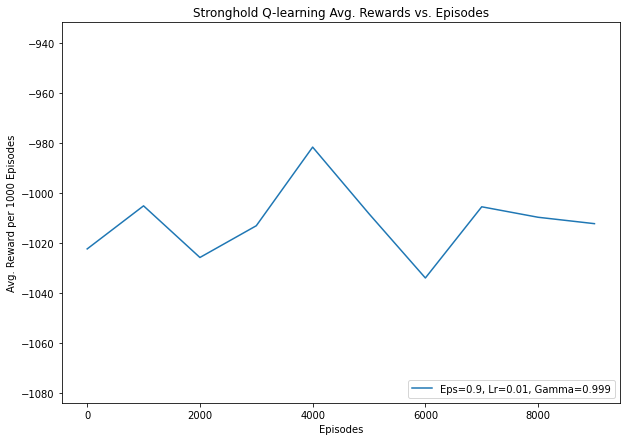

Best Policy


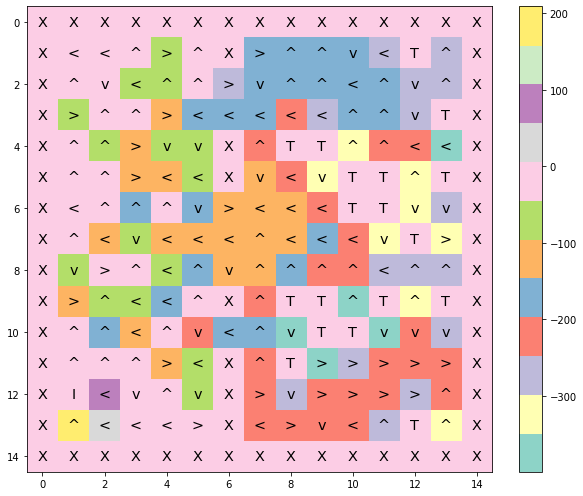

In [11]:
env_size = 15
simplicity = 4 # Simplicity value changed, rest stay the same
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999           
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ks4 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  603.2058186531067


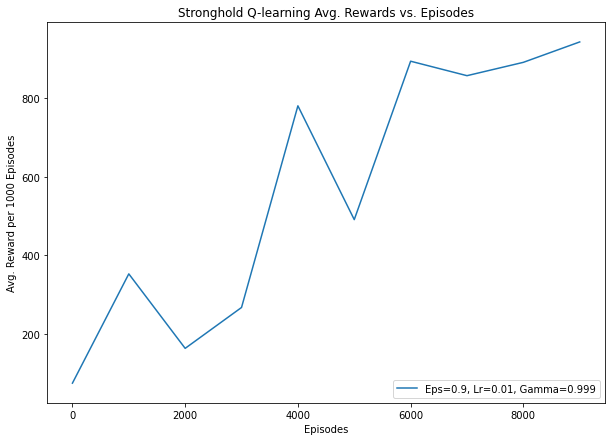

Best Policy


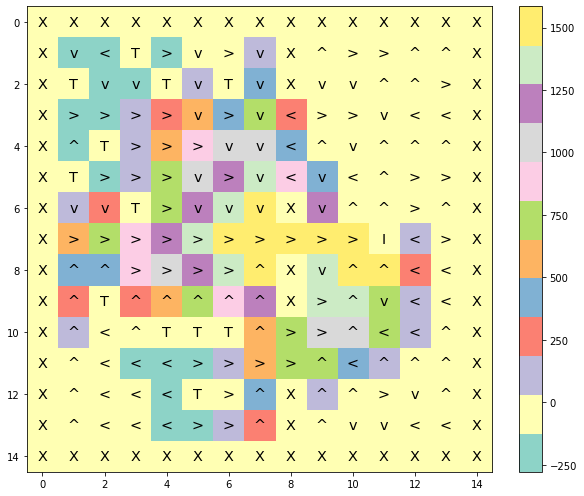

In [12]:
env_size = 15
simplicity = 6 # Simplicity value changed, rest stay the same
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999           
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ks6 = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 226
Time taken for Q-learning is,  365.5797917842865


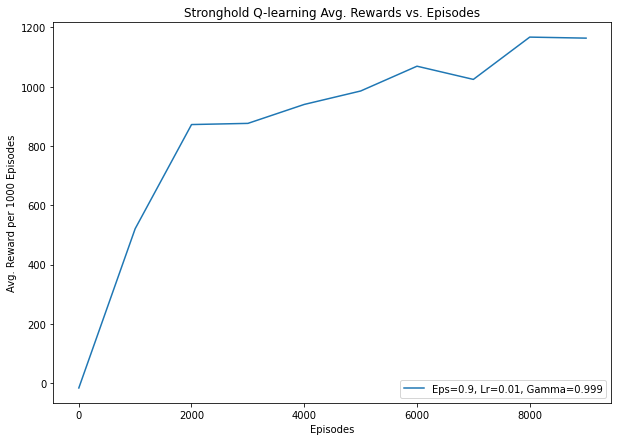

Best Policy


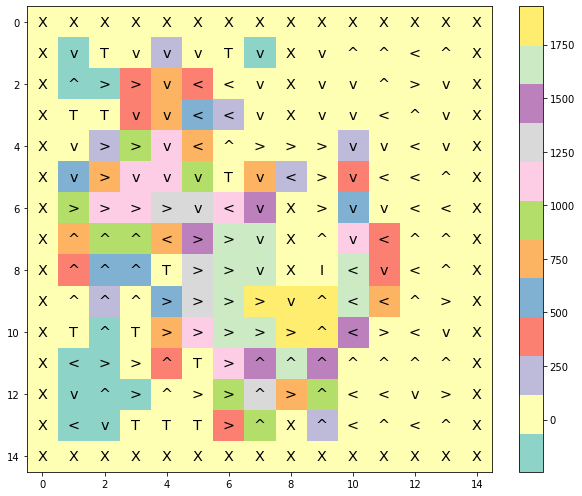

In [13]:
env_size = 15
simplicity = 8 # Simplicity value changed, rest stay the same
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999            
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1ks8 = avg_eval_rewards

In [5]:
# # loading the results for simplicity variation graph
# avg_eval_rewards_e09lr01d999e10kl1ks2 = pickle.load(open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks2'+'.q-learn', 'rb'))
# avg_eval_rewards_e09lr01d999e10kl1ks3 = pickle.load(open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks3'+'.q-learn', 'rb'))         
# avg_eval_rewards_e09lr01d999e10kl1ks4 = pickle.load(open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks4'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d999e10kl1ks6 = pickle.load(open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks6'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d999e10kl1ks8 = pickle.load(open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks8'+'.q-learn', 'rb')) 

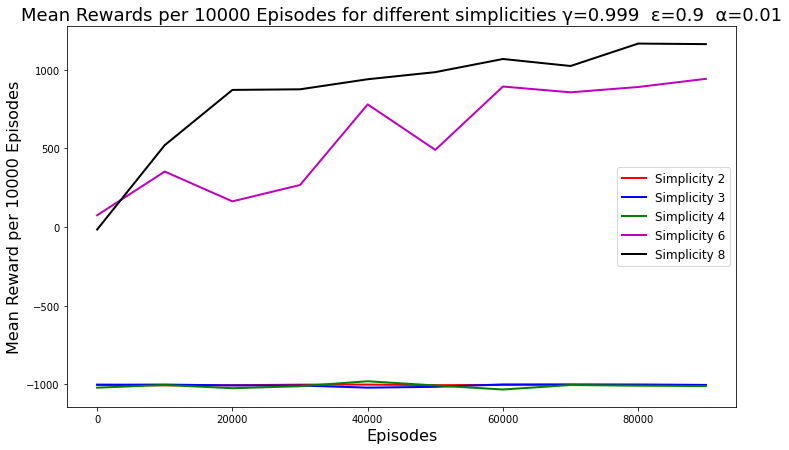

In [7]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ks2, 'r', linewidth=2.0, label='Simplicity 2')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ks3, 'b', linewidth=2.0, label='Simplicity 3')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ks4, 'g', linewidth=2.0, label='Simplicity 4')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ks6, 'm', linewidth=2.0, label='Simplicity 6')
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1ks8, 'k', linewidth=2.0, label='Simplicity 8')
plt.title('Mean Rewards per 10000 Episodes for different simplicities γ=0.999  ε=0.9  α=0.01', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 10000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
# plt.savefig('results/simplicity_diff/Different_simplicity_values')
plt.show()

In [14]:
# # saving the results for simplicity variation graph
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ks2, open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks2'+'.q-learn', 'wb'), -1)         
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ks3, open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks3'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ks4, open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks4'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ks6, open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks6'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1ks8, open('results/simplicity_diff/avg_eval_rewards_e09lr01d999e10kl1ks8'+'.q-learn', 'wb'), -1) 

## Investigating Gamma Variation with Constant Learning Rate and Epsilon - Stronghold size 11x11 Simplicity Level 6

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  275.18645000457764


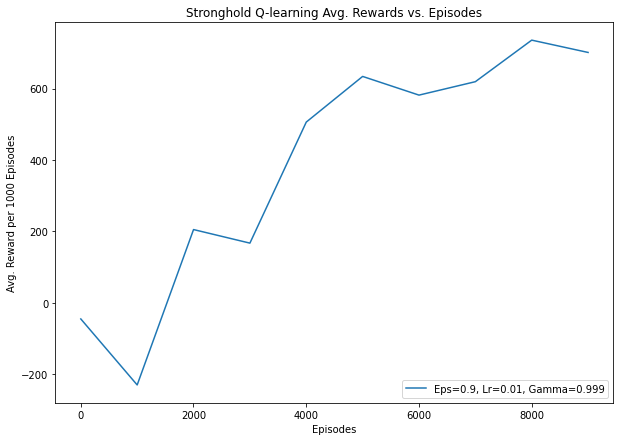

Best Policy


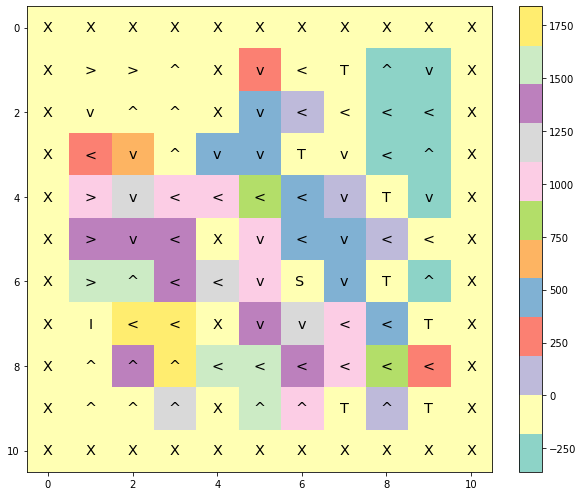

In [32]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.999            # gamma changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  415.9453971385956


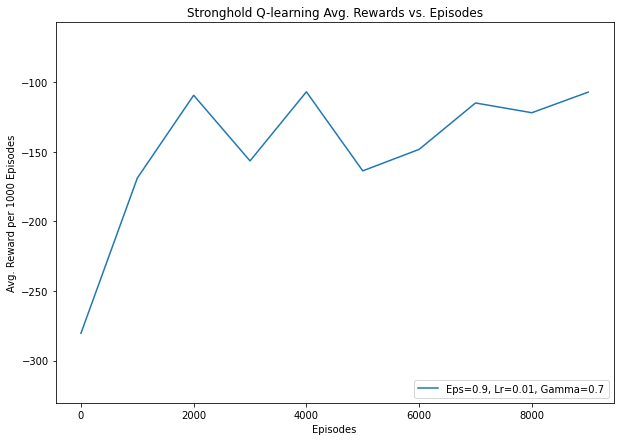

Best Policy


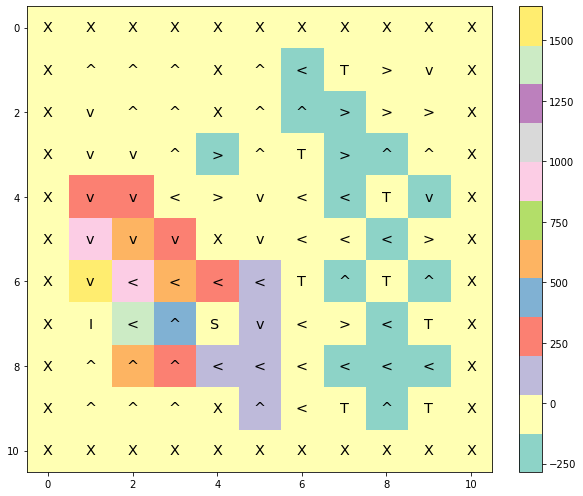

In [33]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.7            # discount factor changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d700e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  473.89807868003845


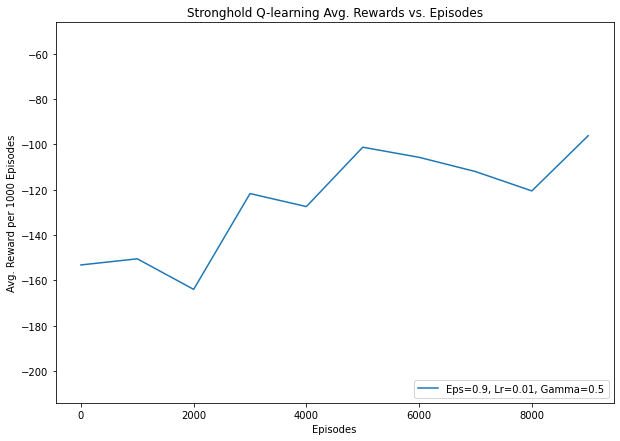

Best Policy


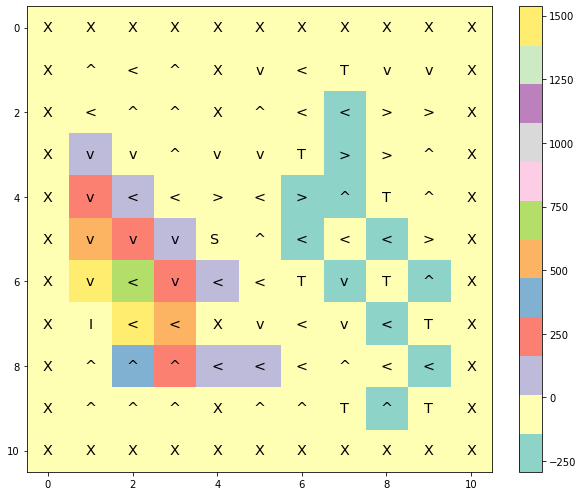

In [34]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.5            # discount factor changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d500e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  382.4772775173187


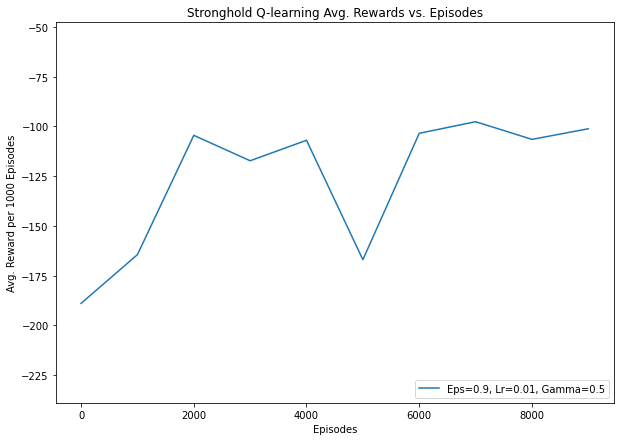

Best Policy


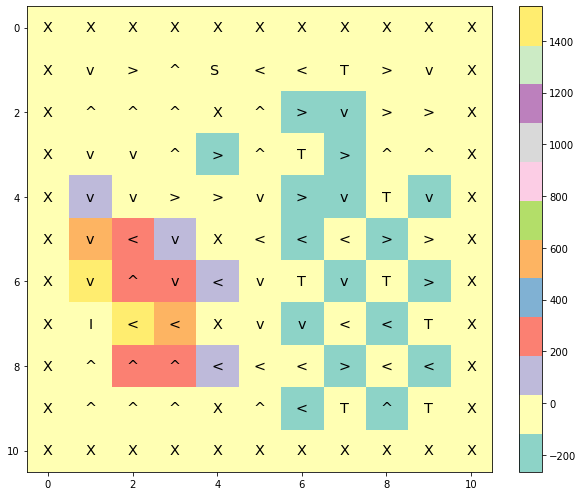

In [35]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.5            # discount factor changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d500e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  375.63842511177063


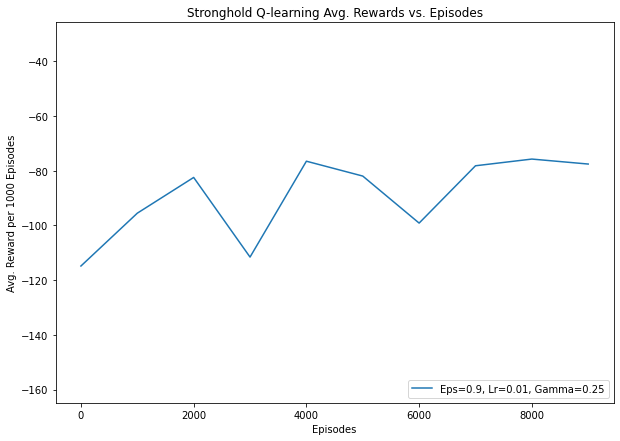

Best Policy


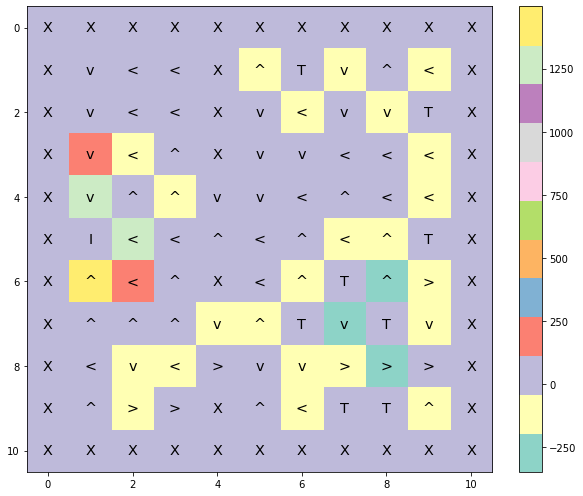

In [3]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.25            # discount factor changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d250e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  229.9839472770691


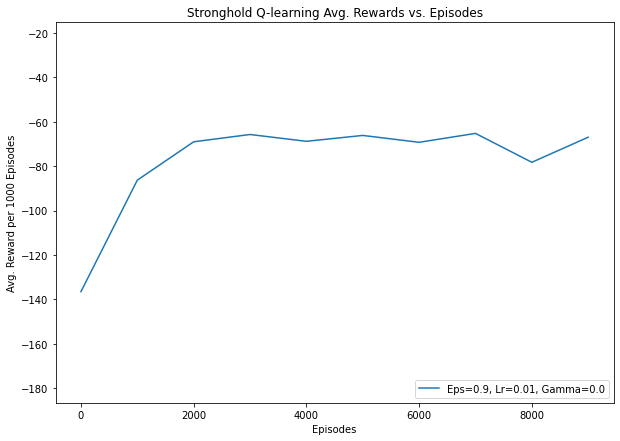

Best Policy


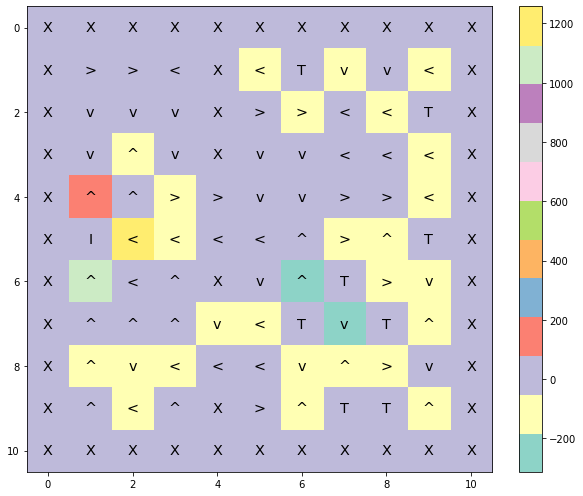

In [4]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9         
lr = 0.01               
discount = 0.0            # discount factor changed, rest stay the same
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d000e10kl1k = avg_eval_rewards

In [9]:
# # loading the results for gamma variation graph
# avg_eval_rewards_e09lr01d999e10kl1k = pickle.load(open('results/gamma_diff/avg_eval_rewards_e09lr01d999e10kl1k'+'.q-learn', 'rb'))
# avg_eval_rewards_e09lr01d700e10kl1k = pickle.load(open('results/gamma_diff/avg_eval_rewards_e09lr01d700e10kl1k'+'.q-learn', 'rb'))         
# avg_eval_rewards_e09lr01d500e10kl1k = pickle.load(open('results/gamma_diff/avg_eval_rewards_e09lr01d500e10kl1k'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d250e10kl1k = pickle.load(open('results/gamma_diff/avg_eval_rewards_e09lr01d250e10kl1k'+'.q-learn', 'rb')) 
# avg_eval_rewards_e09lr01d000e10kl1k = pickle.load(open('results/gamma_diff/avg_eval_rewards_e09lr01d000e10kl1k'+'.q-learn', 'rb')) 

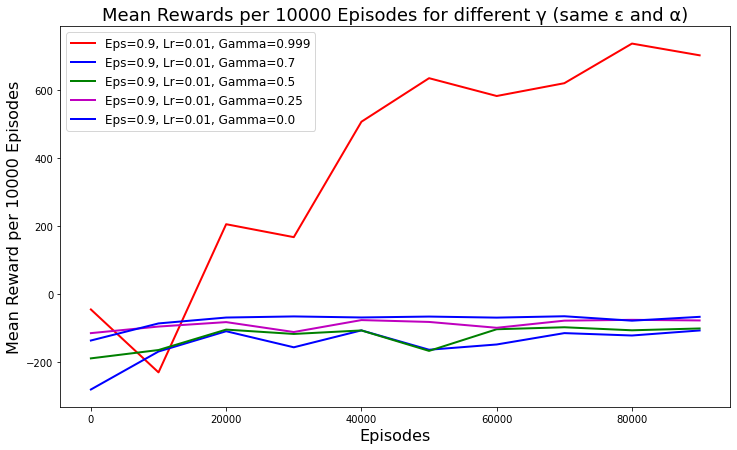

In [10]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d999e10kl1k, 'r', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d700e10kl1k, 'b', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.7))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d500e10kl1k, 'g', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.5))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d250e10kl1k, 'm', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.25))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e09lr01d000e10kl1k, 'b', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.0))
plt.title('Mean Rewards per 10000 Episodes for different γ (same ε and α)', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 10000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
# plt.savefig('results/gamma_diff/Different_gamma_values')
plt.show()

In [5]:
# # saving the results for gamma variation graph
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1k, open('results/gamma_diff/avg_eval_rewards_e09lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr01d700e10kl1k, open('results/gamma_diff/avg_eval_rewards_e09lr01d700e10kl1k'+'.q-learn', 'wb'), -1)        
# pickle.dump(avg_eval_rewards_e09lr01d500e10kl1k, open('results/gamma_diff/avg_eval_rewards_e09lr01d500e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d250e10kl1k, open('results/gamma_diff/avg_eval_rewards_e09lr01d250e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr01d000e10kl1k, open('results/gamma_diff/avg_eval_rewards_e09lr01d000e10kl1k'+'.q-learn', 'wb'), -1) 

## Investigating Epsilon Variation with Constant Learning Rate and Gamma - Stronghold size 11x11 Simplicity Level 6

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  196.07986974716187


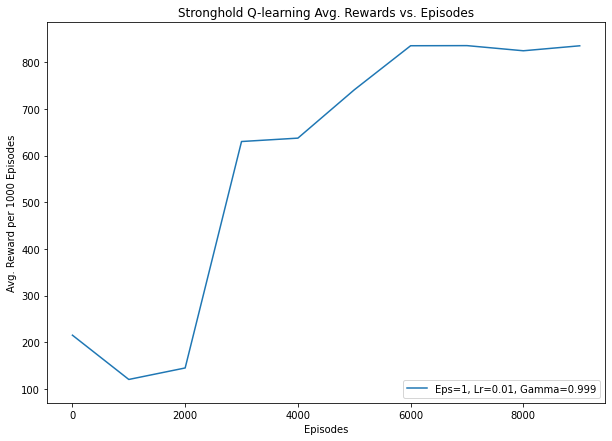

Best Policy


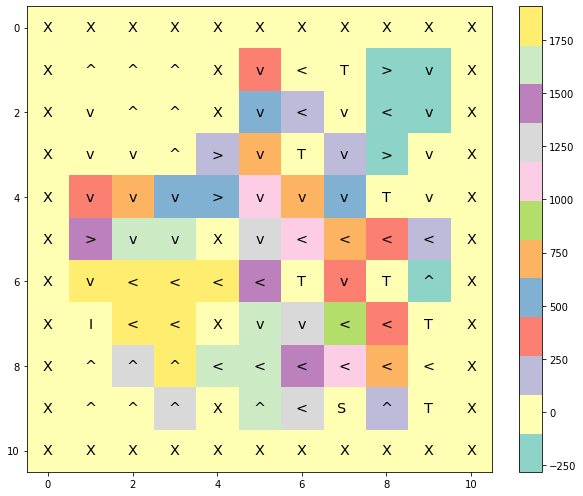

In [3]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 1         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e1lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  195.3264455795288


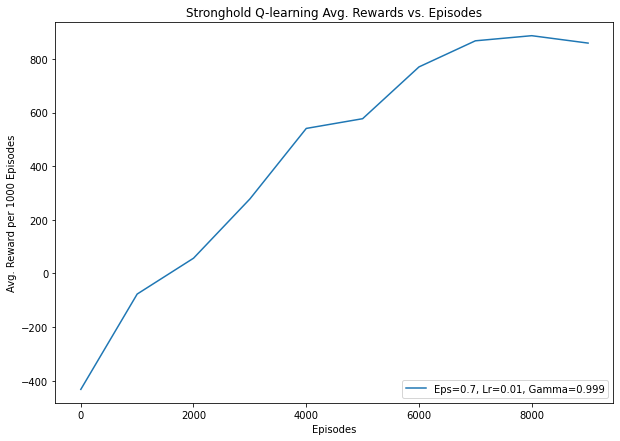

Best Policy


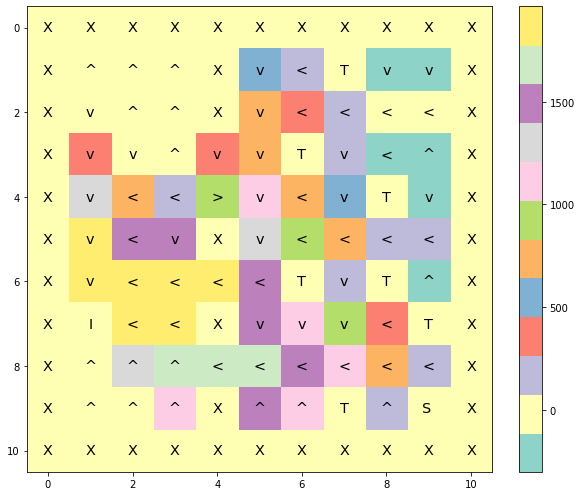

In [4]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.7         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e07lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  235.65127778053284


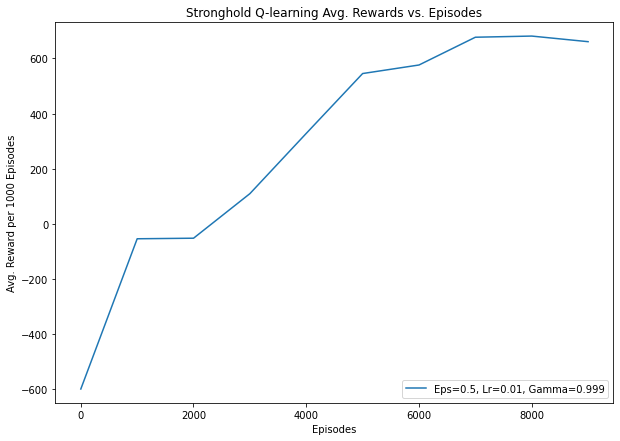

Best Policy


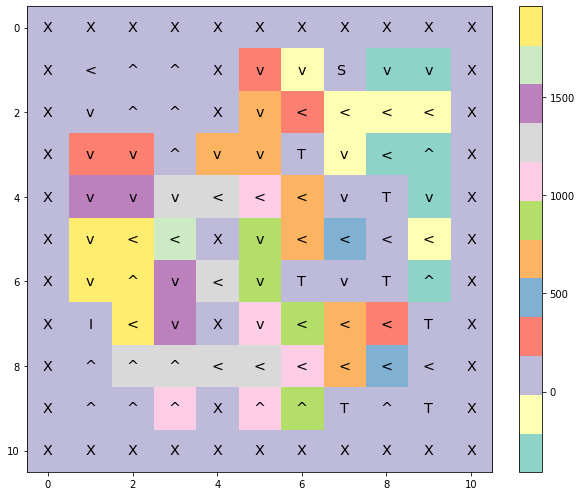

In [5]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.5         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e05lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  185.22041845321655


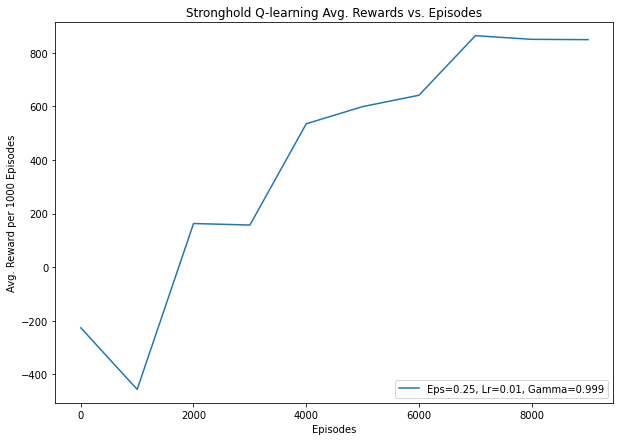

Best Policy


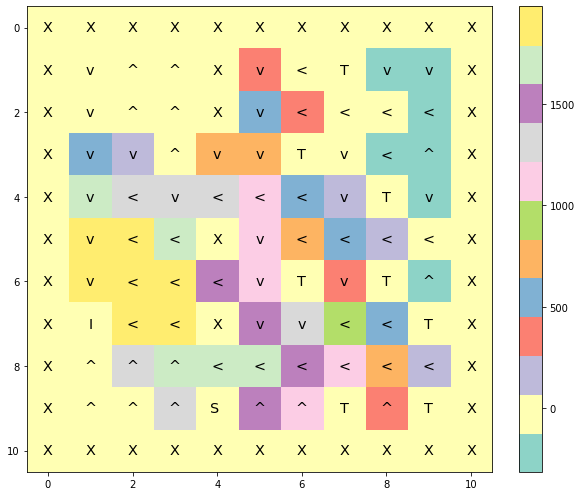

In [11]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.25         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e025lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  214.48396468162537


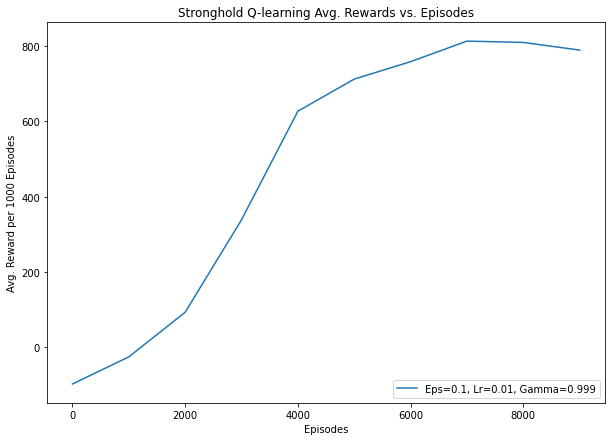

Best Policy


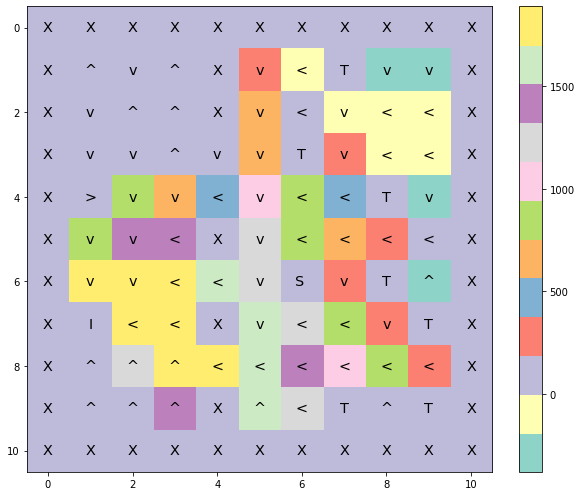

In [6]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.1         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e01lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  219.03576016426086


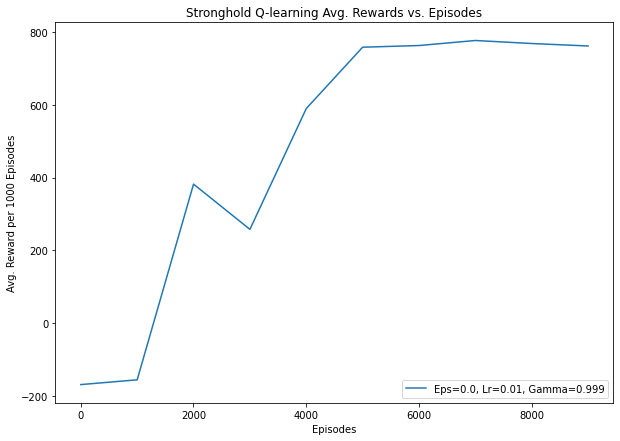

Best Policy


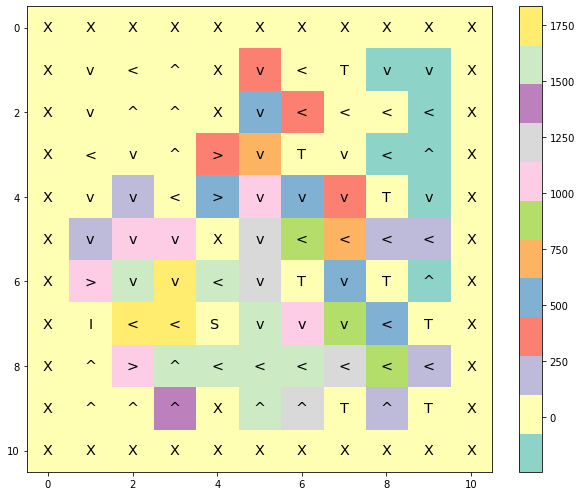

In [7]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.0         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e00lr01d999e10kl1k = avg_eval_rewards

In [11]:
# # loading the results for epsilon variation graph
# avg_eval_rewards_e1lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e1lr01d999e10kl1k'+'.q-learn', 'rb'))         
# avg_eval_rewards_e07lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e07lr01d999e10kl1k'+'.q-learn', 'rb'))
# avg_eval_rewards_e05lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e05lr01d999e10kl1k'+'.q-learn', 'rb'))
# avg_eval_rewards_e025lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e025lr01d999e10kl1k'+'.q-learn', 'rb'))           
# avg_eval_rewards_e01lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e01lr01d999e10kl1k'+'.q-learn', 'rb'))
# avg_eval_rewards_e00lr01d999e10kl1k = pickle.load(open('results/eps_diff/avg_eval_rewards_e00lr01d999e10kl1k'+'.q-learn', 'rb' ))

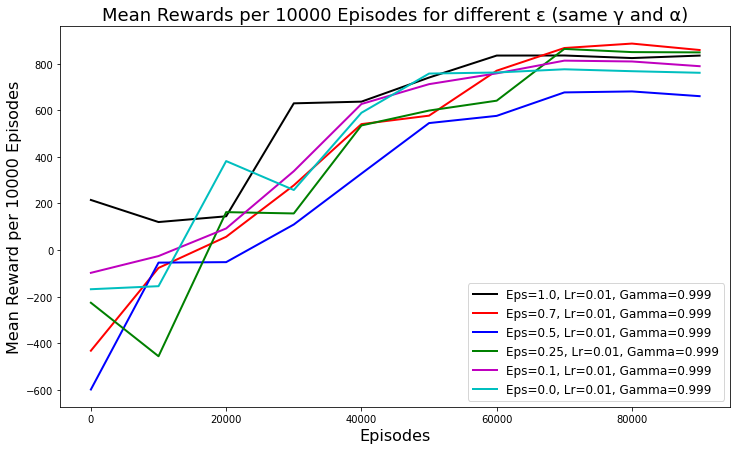

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e1lr01d999e10kl1k, 'k', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(1.0, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e07lr01d999e10kl1k, 'r', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.7, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e05lr01d999e10kl1k, 'b', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.5, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e025lr01d999e10kl1k, 'g', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.25, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e01lr01d999e10kl1k, 'm', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.1, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000) , avg_eval_rewards_e00lr01d999e10kl1k, 'c', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.0, 0.01, 0.999))
plt.title('Mean Rewards per 10000 Episodes for different ε (same γ and α)', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 10000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.savefig('results/eps_diff/Different_epsilon_values')
plt.show()

In [21]:
# # saving the results for epsilon variation graph
# pickle.dump(avg_eval_rewards_e1lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e1lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e07lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e07lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e05lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e05lr01d999e10kl1k'+'.q-learn', 'wb'), -1)         
# pickle.dump(avg_eval_rewards_e025lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e025lr01d999e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e01lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e01lr01d999e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e00lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e00lr01d999e10kl1k'+'.q-learn', 'wb'), -1) 

## Investigating Learning Rate Variation with Constant Epsilon and Gamma - Stronghold size 11x11 Simplicity Level 6

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  198.44862914085388


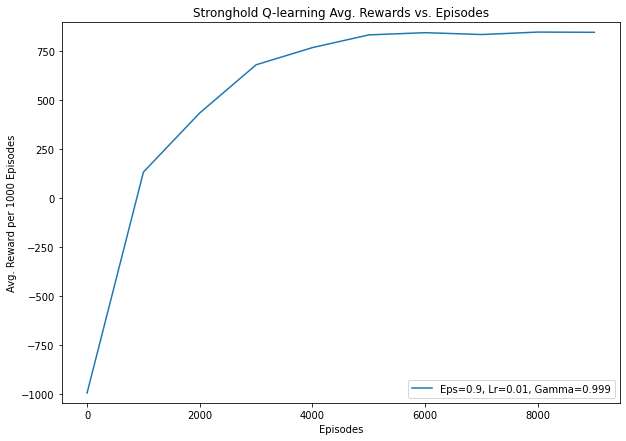

Best Policy


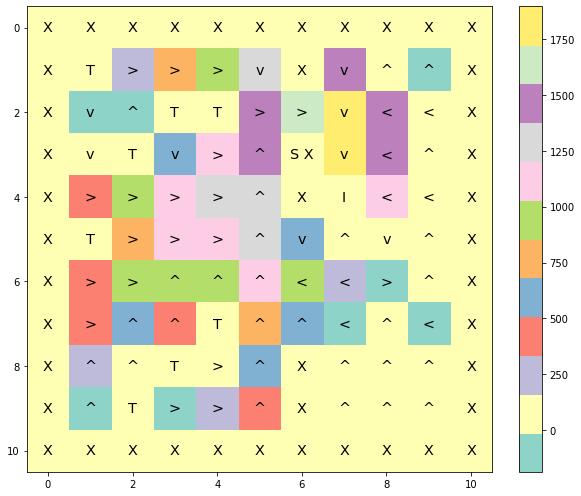

In [60]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
# ε is assigned a real number between 0 and 1.
# With probability ε the agent chooses a random action.
# With probability 1-ε the agent acts greedily.
lr = 0.01               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  289.22807693481445


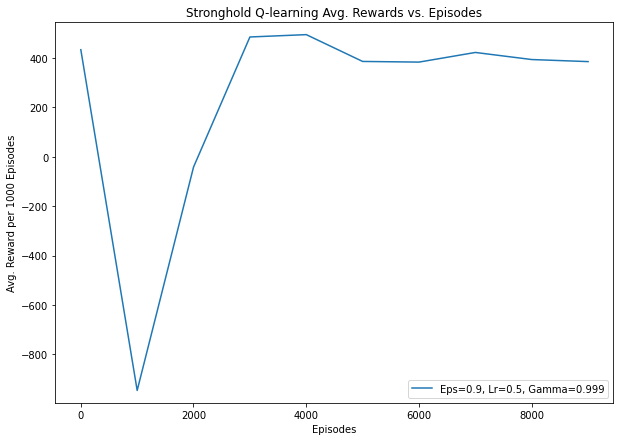

Best Policy


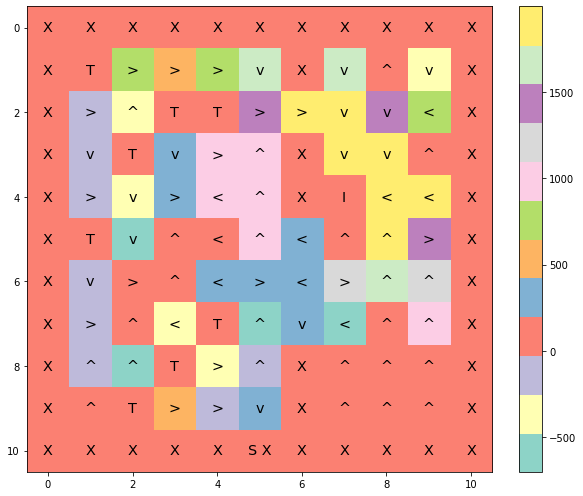

Some Q-table values
               1            2            3            4
13   -956.195974  -962.268399  -937.562500   656.192865
14   -939.990444  -937.531250  -920.182906   451.243063
15   -826.544601  -840.405660  -812.247977   669.111148
16   -480.699190  1651.345555  -504.145423  -541.145485
18   -786.454622  1622.534461  -805.528666  -750.374813
27   -763.070775  -841.895916  -750.000000  1496.819969
28     -6.366132    -6.320061    -6.600050  1923.214260
29     -2.371764  1972.872395    -2.781912    -2.509833
30   -500.250000  1411.973882  -575.695138  -579.809209
31   -664.081113  -750.000000   813.192837  -823.640785
36   -984.375000   294.458889  -976.608347  -980.729063
37   -930.788498  -909.750947  -871.744777  1094.292687
38   1065.882457  -569.809181  -549.828656  -555.622207
40     -0.749750  1994.805777     0.000000     0.000000
41   -463.407489  1951.802516  -437.227927  -500.000000
47   -720.609787  -726.262659  -724.586760   295.282217
48   -677.848449  -621.94477

In [36]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.5               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr5d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  201.1975040435791


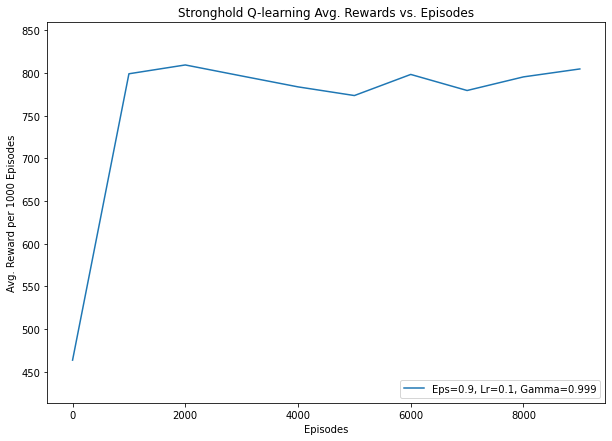

Best Policy


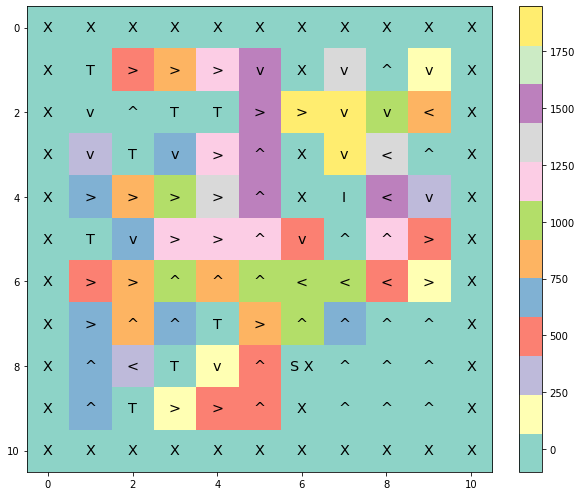

Some Q-table values
               1            2            3            4
13   -470.415012  -486.343792  -463.316793   576.284390
14   -422.742118  -413.424045  -438.944022   876.827170
15   -418.794382  -403.136883  -382.926322  1153.047339
16   -210.829114  1449.058764  -208.496129  -209.667456
18     -0.200000  1376.555976  -100.000000  -100.000000
20   -101.799190    74.292035  -190.000000  -101.259622
23   -651.321560    43.124061  -655.861525  -650.285193
27   -347.500867  -344.213078  -354.668415  1592.559990
28    -16.857541   -27.484823   -14.156583  1791.028890
29     -0.324941  1856.377543    -0.314402    -0.280990
30   -100.090000  1034.248915    -0.113982    -0.118981
31     -0.100000    -0.200000   793.917201     0.000000
34   -589.450829   335.162553  -597.138403  -607.054170
36   -572.645922   644.288998  -561.080379  -561.091917
37   -485.489023  -483.674258  -511.156646  1098.708561
38   1503.767044  -275.594023  -285.553395  -270.596951
40     -0.200000  1948.02609

In [34]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.1               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr1d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  243.7899820804596


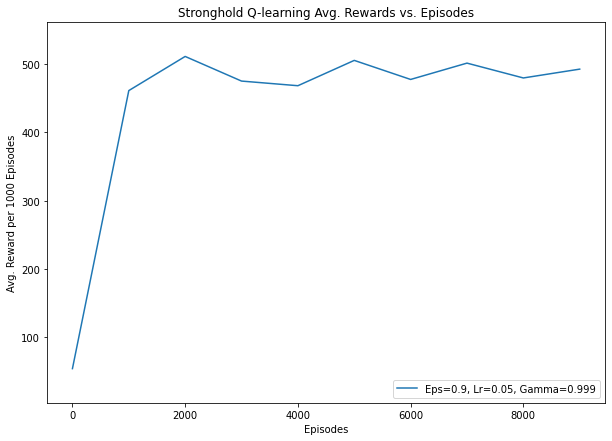

Best Policy


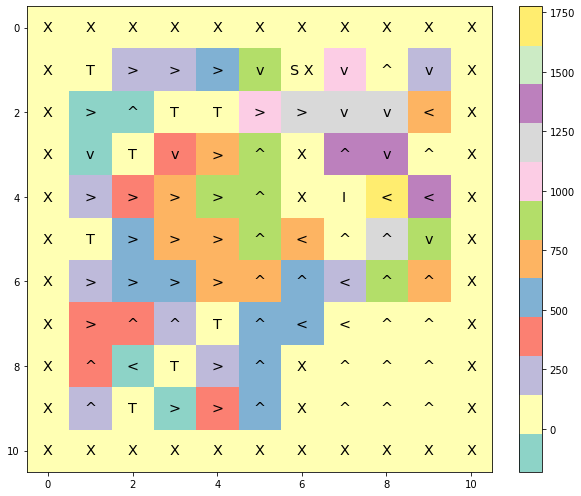

Some Q-table values
               1            2            3            4
13   -428.545186  -434.536915  -432.718221   150.910511
14   -355.894616  -352.240543  -362.450904   280.867171
15   -237.946096  -261.367223  -230.014081   562.414459
16    -75.757547   914.060465   -76.067207   -73.652518
18   -100.476401  1034.615150   -98.145903   -97.680495
20    -50.664900   272.147753   -50.000000   -51.358580
27   -152.707366  -177.792706  -179.786731  1096.432047
28     -5.410578    -7.768639    -7.602714  1257.692098
29     -0.403185  1281.053753    -0.050000    -0.050000
30    -50.000000  1161.554314    -0.985090   -11.364225
31    -87.609623   -97.253404   693.563337   -97.963524
36   -360.378287   318.260997  -358.522976  -353.082357
37   -257.558012  -228.855178  -250.017422   721.568966
38    951.556416   -96.050401   -95.095390   -96.923775
40   1393.230592     0.000000     0.000000     0.000000
41    -27.680759  1347.149669   -45.530277   -50.000000
45   -330.363244  -331.29807

In [33]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.05               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr05d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  242.66899728775024


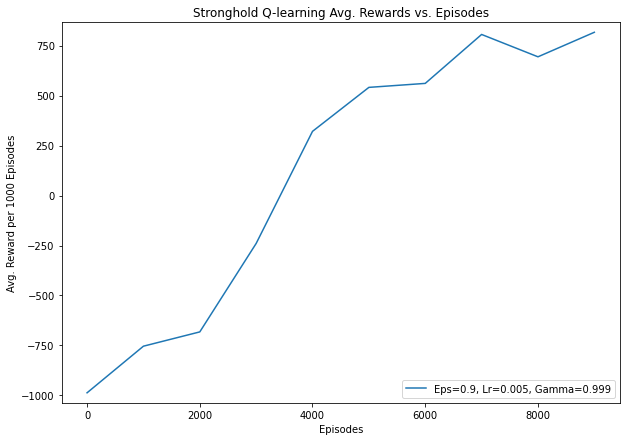

Best Policy


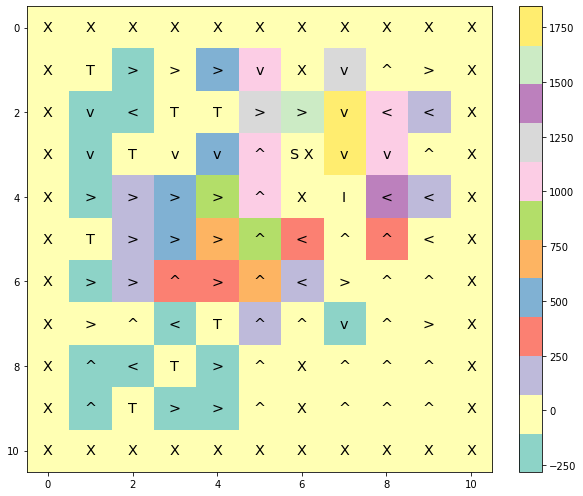

Some Q-table values
              1            2            3            4
14  -149.565999  -152.484211  -149.486371    40.562732
15  -112.374094  -112.838871  -114.993609   531.668583
16   -29.227837  1053.486062   -29.073973   -29.082630
18   -22.100925  1201.678066   -24.972863   -21.526786
27   -70.000596   -69.755039   -72.209620  1191.826104
28    -0.422791    -0.546997    -0.490573  1584.384020
29    -0.045078  1674.322814    -0.041288    -0.049507
30   -14.653021   -16.702145   967.335010   -14.240047
31    -9.993649    -9.975000    89.853019    -9.659642
36  -210.549758     6.431107  -210.850070  -208.978234
37  -139.556589   486.240373  -136.833546  -136.507721
38  1044.637330   -37.344009   -37.285575   -37.130279
40    -0.010052  1845.123158    -0.005025    -0.005025
41    -8.060927   991.778207    -5.009950    -5.004975
46  -159.956038  -160.285358  -158.137154   115.223817
47   -59.811693   -59.520793   -59.587553   561.300742
48   -43.146029   -43.113619   -43.243844   8

In [31]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.005           #0.001 is too low
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr005d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  133.3985641002655


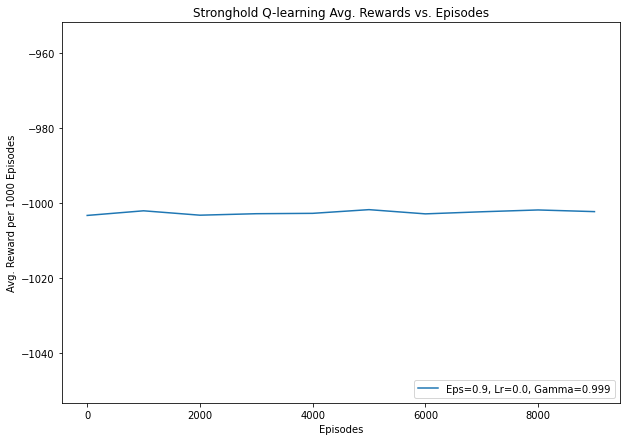

Best Policy


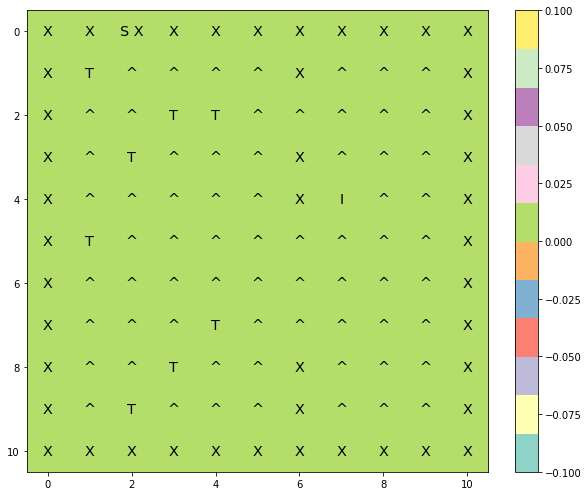

In [48]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.0               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr0d999e10kl1k = avg_eval_rewards

In [13]:
# loading the results for learning rate variation
avg_eval_rewards_e09lr0d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr0d999e10kl1k'+'.q-learn', 'rb'))         
avg_eval_rewards_e09lr005d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr005d999e10kl1k'+'.q-learn', 'rb'))
avg_eval_rewards_e09lr01d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr01d999e10kl1k'+'.q-learn', 'rb'))
avg_eval_rewards_e09lr05d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr05d999e10kl1k'+'.q-learn', 'rb'))          
avg_eval_rewards_e09lr1d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr1d999e10kl1k'+'.q-learn', 'rb'))
avg_eval_rewards_e09lr5d999e10kl1k = pickle.load(open('results/lr_diff/avg_eval_rewards_e09lr5d999e10kl1k'+'.q-learn', 'rb' ))

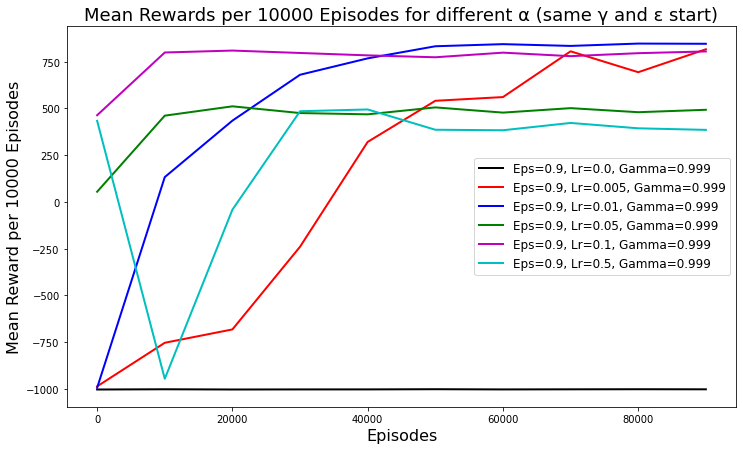

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr0d999e10kl1k, 'k', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.0, 0.999))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr005d999e10kl1k, 'r', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.005, 0.999))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr01d999e10kl1k, 'b', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.999))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr05d999e10kl1k, 'g', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.05, 0.999))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr1d999e10kl1k, 'm', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.1, 0.999))
plt.plot(np.arange(0, 100000, 10000), avg_eval_rewards_e09lr5d999e10kl1k, 'c', linewidth=2.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.5, 0.999))
plt.title('Mean Rewards per 10000 Episodes for different α (same γ and ε start)', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 10000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
# plt.savefig('results/lr_diff/Different_learning_rates')
plt.show()

In [ ]:
# # saving the results for learning rate variation
# pickle.dump(avg_eval_rewards_e09lr0d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr0d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr005d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr005d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr05d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr05d999e10kl1k'+'.q-learn', 'wb'), -1)         
# pickle.dump(avg_eval_rewards_e09lr1d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr1d999e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr5d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr5d999e10kl1k'+'.q-learn', 'wb'), -1) 